In [1]:
import numpy as np
import matplotlib.pyplot as plt
import a5_utils
import cv2

# Exercise 1

a)

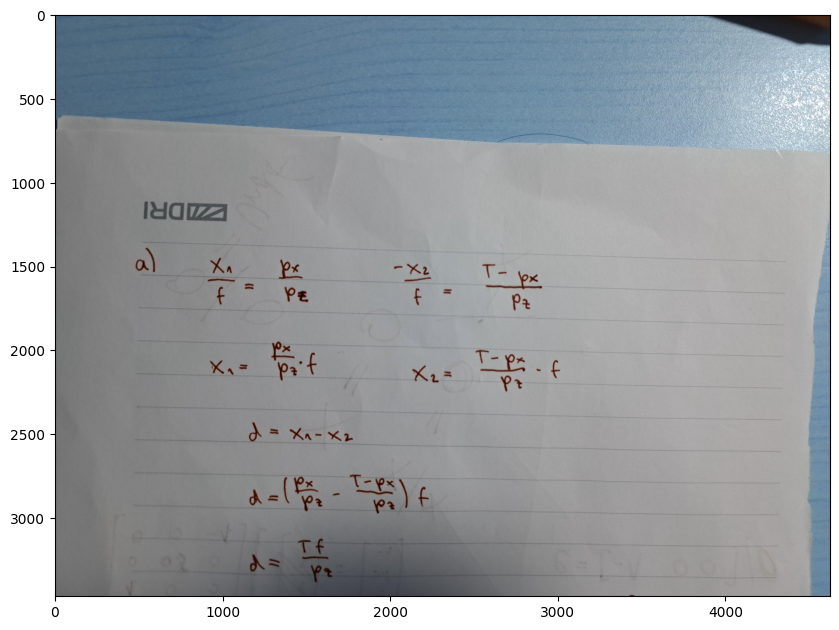

In [2]:
izpeljava1 = cv2.imread('data/izpeljava1.jpg')
plt.figure(figsize=(10, 20))
plt.imshow(izpeljava1)

A: When an object is further away, the disparity decreases 

b)

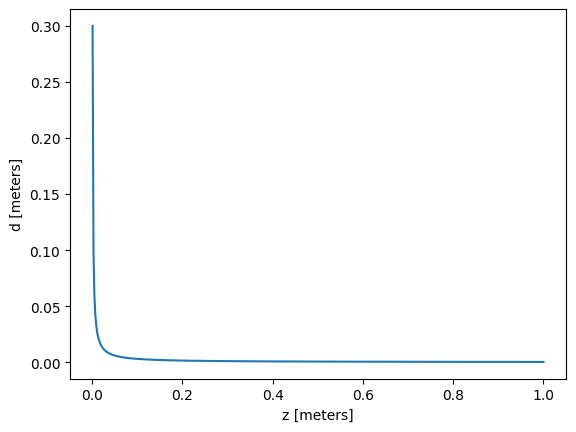

In [3]:
f = 2.5e-3
T = 0.12

z = np.linspace(0.001, 1, 500)
d = f*T/z

plt.xlabel('z [meters]')
plt.ylabel('d [meters]')
plt.plot(z, d)

c)

In [4]:
f = 2.5e-3
T = 0.12
px_width = 7.4e-6
sensor_width = 648*px_width

measurements = [(550, 300), (550, 540)]

for left, right in measurements:
    x_left = left*px_width - sensor_width / 2
    x_right = right*px_width - sensor_width / 2
    disparity = x_left - x_right
    # the equtaion from before
    p_z = f*T / disparity
    print("p_z:", p_z, "meters")

p_z: 0.16216216216216217 meters
p_z: 4.0540540540540855 meters


d)

In [5]:
def patch(I, x, y, size):
    return I[max(0, y-size):min(y+size+1, I.shape[0]), max(0, x-size):min(x+size+1, I.shape[1])]

In [6]:
def NCC(X, Y):
    if X.shape != Y.shape:
        return -1
    
    X = X.flatten()
    Y = Y.flatten()
    N = len(X)
    mx = np.mean(X)
    my = np.mean(Y)
    
    return 1/N * np.sum((X-mx)*(Y-my))/(np.sqrt(1/N * np.sum((X-mx)**2))*np.sqrt(1/N * np.sum((Y-my)**2)))

In [19]:
def disparity(I1, I2):
    patch_size = 10
    disparity = np.zeros(I1.shape)
    
    for y in range(I1.shape[0]):
        for x in range(I1.shape[1]):
            X = patch(I1, x, y, patch_size)
            max_ncc = 0
            
            # disparity from -10 to 10 pixels
            for d in range(-35, 35):
                Y = patch(I2, x+d, y, patch_size)
                ncc = NCC(X,Y)
                if ncc > max_ncc:
                    max_ncc = ncc
                    disparity[y,x] = d
    return disparity

/var/folders/cr/14yjwnk14zdcpjclx10yprwc0000gp/T/ipykernel_32160/1754558602.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return 1/N * np.sum((X-mx)*(Y-my))/(np.sqrt(1/N * np.sum((X-mx)**2))*np.sqrt(1/N * np.sum((Y-my)**2)))


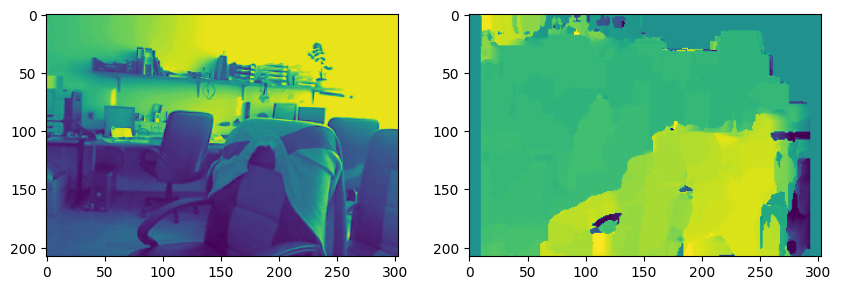

In [20]:
I_left = cv2.cvtColor(cv2.imread('data/disparity/office_left.png'), cv2.COLOR_BGR2GRAY).astype('float64')
I_right = cv2.cvtColor(cv2.imread('data/disparity/office_right.png'), cv2.COLOR_BGR2GRAY).astype('float64')
I_left_reduced = cv2.resize(I_left, dsize=(I_left.shape[1]//2, I_left.shape[0]//2)) 
I_right_reduced = cv2.resize(I_right, dsize=(I_right.shape[1]//2, I_right.shape[0]//2))

disp_left = disparity(I_left_reduced, I_right_reduced)

plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(I_left_reduced)
plt.subplot(1, 2, 2)
plt.imshow(disp_left)

A: no, for objects that are smaller than the patch size we observe distortions.

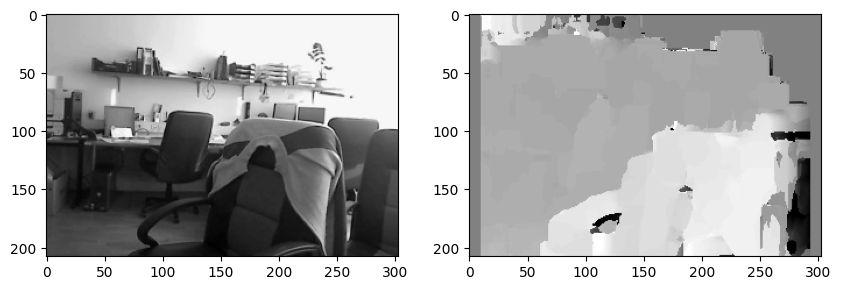

In [22]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(I_left_reduced, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(disp_left, cmap='gray')

e)

In [9]:
def median_patch_filter(I, w):
	res = np.zeros(I.shape)
	
	for y in range(I.shape[0]):
		for x in range(I.shape[1]):
			res[y,x] = np.median(patch(I, x, y, w))
	return res

/var/folders/cr/14yjwnk14zdcpjclx10yprwc0000gp/T/ipykernel_32160/1754558602.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return 1/N * np.sum((X-mx)*(Y-my))/(np.sqrt(1/N * np.sum((X-mx)**2))*np.sqrt(1/N * np.sum((Y-my)**2)))


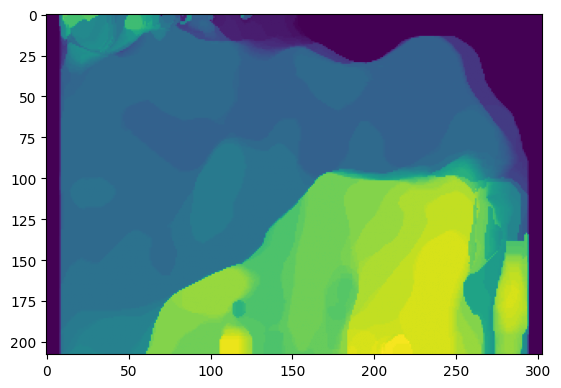

In [21]:
disp_right = disparity(I_right_reduced, I_left_reduced)

patch_size = 11
disp_left_smooth = median_patch_filter(disp_left, patch_size)
disp_right_smooth = median_patch_filter(disp_right, patch_size)

disp_merged = np.zeros(disp_left_smooth.shape)

for y in range(disp_left_smooth.shape[0]):
    for x in range(disp_left_smooth.shape[1]):
        dl = disp_left_smooth[y, x]
        dr = disp_right_smooth[y, round(x + dl)]

        disp_merged[y,x] = np.abs(dl) + np.abs(dr)
        # disp_merged[y,x] = (dl + dr) / 2

plt.imshow(disp_merged)

# Exercise 2

a)

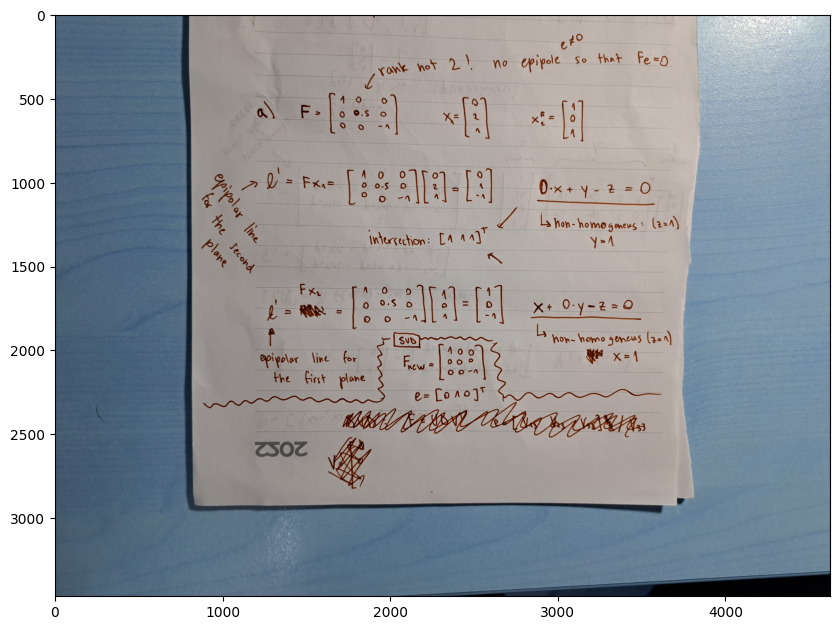

In [11]:
izpeljava2 = cv2.imread('data/izpeljava2.jpg')
plt.figure(figsize=(10, 20))
plt.imshow(izpeljava2)

b)

In [12]:
def fundamental_matrix(p1, p2):
    p1, T1 = a5_utils.normalize_points(p1)
    p2, T2 = a5_utils.normalize_points(p2)
    up = p1[:,0]
    vp = p1[:,1]
    u = p2[:,0]
    v = p2[:,1]

    A = np.stack([u*up, u*vp, u, v*up, v*vp, v, up, vp, np.ones(u.shape)]).T
    U, S, VT = np.linalg.svd(A)    
    Ft = VT.T[:,-1].reshape((3,3))

    # reduce fundamental matrix rank
    U, S, VT = np.linalg.svd(Ft)
    S[-1] = 0
    F = (U * S) @ VT
    
    # apply normalization transformations
    F = T2.T @ F @ T1
    return F

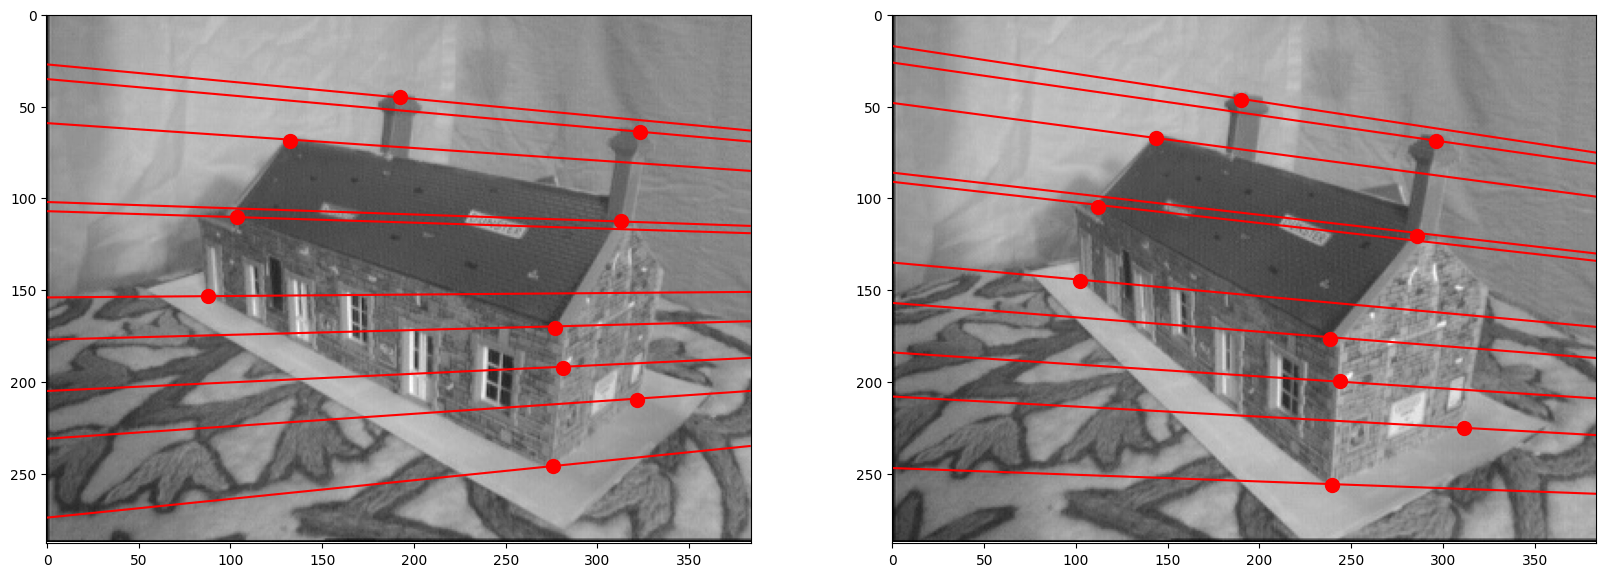

In [13]:
with open("data/epipolar/house_points.txt", "r") as f:
    points = np.array(f.read().split()).reshape((-1,4)).astype('float')
    p1 = points[:,0:2]
    p2 = points[:,2:4]

house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')

F = fundamental_matrix(p1, p2)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(house1, cmap="gray")
for point in p2:
    point_vec = np.array([point[0], point[1], 1])
    l = F.T @ point_vec
    a5_utils.draw_epiline(l, house1.shape[0], house1.shape[1])
plt.scatter(p1[:, 0], p1[:, 1], color="red", s=100)

plt.subplot(1, 2, 2)
plt.imshow(house2, cmap="gray")
for point in p1:
    point_vec = np.array([point[0], point[1], 1])
    l = F @ point_vec
    a5_utils.draw_epiline(l, house2.shape[0], house2.shape[1])
plt.scatter(p2[:, 0], p2[:, 1], color="red", s=100)

c)

In [14]:
def reprojection_error(p1, p2, F):
    p1_vec = np.array([p1[0], p1[1], 1])
    p2_vec = np.array([p2[0], p2[1], 1])
    l1 = F.T @ p2_vec
    l2 = F @ p1_vec

    d1 = np.abs(l1[0]*p1[0] + l1[1]*p1[1] + l1[2]) / np.sqrt(l1[0]**2 + l1[1]**2)
    d2 = np.abs(l2[0]*p2[0] + l2[1]*p2[1] + l2[2]) / np.sqrt(l2[0]**2 + l2[1]**2)

    return (d1 + d2) / 2

In [15]:
with open("data/epipolar/house_points.txt", "r") as f:
    points = np.array(f.read().split()).reshape((-1,4)).astype('float64')
    p1 = points[:,0:2]
    p2 = points[:,2:4]

F = fundamental_matrix(p1, p2)

err1 = reprojection_error(np.array([85, 233]), np.array([67, 219]), F)
print("Error 1:", err1)

S, N = 0, 0
for pt1, pt2 in zip(p1, p2):
    S += reprojection_error(pt1, pt2, F)
    N += 1

print("Error 2:", S / N)

Error 1: 0.14674365570450046
Error 2: 0.33091336980543157


# Exercise 3

a)

In [16]:
def shear_form(v):
    x, y, z = v[0], v[1], v[2]
    return np.array([[0, -z, y], [z, 0, -x], [-y, x, 0]])

In [17]:
def triangulate(corr, P1, P2):
    # corr - correspondences
    points3D = []

    for x0, y0, x1, y1 in corr:
        p1_shear = shear_form([x0, y0, 1])
        p2_shear = shear_form([x1, y1, 1])
        A1 = p1_shear @ P1
        A2 = p2_shear @ P2

        A = [A1[0], A1[1], A2[0], A2[1]]

        _, _, VT = np.linalg.svd(A)
        # eigenvector with the smallest eigenvalue
        X = VT[-1]
        X /= X[-1]
        points3D.append(X[:3])
    return points3D

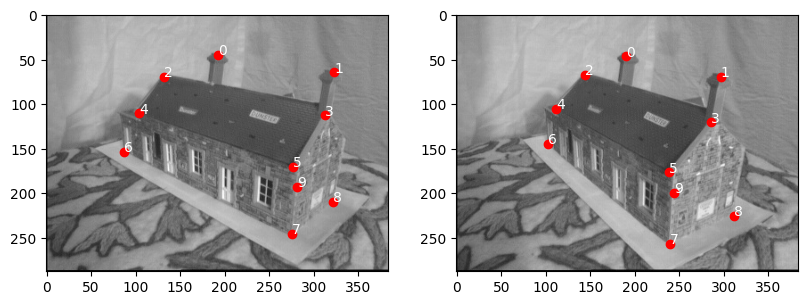

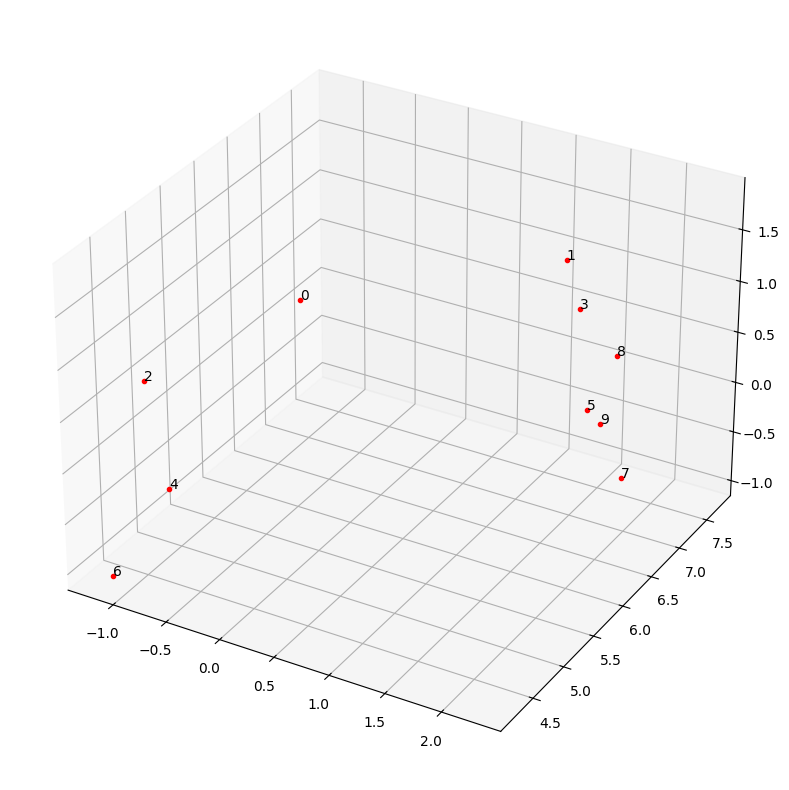

In [18]:
with open("data/epipolar/house_points.txt", "r") as f:
    points = np.array(f.read().split()).reshape((-1,4)).astype('float')
    p1 = points[:,0:2]
    p2 = points[:,2:4]

house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')

with open("data/epipolar/house1_camera.txt", "r") as f:
    P1 = np.array(f.read().split()).reshape((3,4)).astype('float64')
with open("data/epipolar/house2_camera.txt", "r") as f:
    P2 = np.array(f.read().split()).reshape((3,4)).astype('float64')

plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.imshow(house1, cmap="gray")
plt.scatter(p1[:,0], p1[:,1], c='r')
for i, (x, y) in enumerate(p1):
    plt.text(x, y, i, color='white')
    
plt.subplot(1,3,2)
plt.imshow(house2, cmap="gray")
plt.scatter(p2[:,0], p2[:,1], c='r')
for i, (x, y) in enumerate(p2):
    plt.text(x, y, i, color='white')

# triangulate points
points3D = triangulate(points, P1, P2)
T = np.array([[-1, 0, 0], [0, 0, -1], [0, 1, 0]])
# apply transformation T
transformed_points = [T @ p for p in points3D]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i, (x,y,z) in enumerate(transformed_points):
    ax.plot([x],[y],[z], c='r', marker=".")
    ax.text(x, y, z, str(i))